## Reserve Undeliverable with DC OPF
At first, we will take 30 bus system, and modify the 30 bus system

In [68]:
import pandapower as pp
import pandapower.networks as nw
import numpy as np

In [69]:
net = nw.case30() #Loading 30 bus system in net

### Network Overview
We will check total generation capacity and demand. We will then modify it.

In [70]:
gen_capacity = net.gen.max_p_mw.sum() + net.ext_grid.max_p_mw.sum()
demand_load = net.load.p_mw.sum()
print(f"Total Capacity in MW : {gen_capacity} \n")
print(f"Total Demand in MW : {demand_load}")

Total Capacity in MW : 335.0 

Total Demand in MW : 189.2


### Modifying the network
Reducing the generation capacity to encourage undeliverable reserve in contingency

In [71]:
net.gen.drop(index = [0], inplace = True)
net.gen.reset_index(inplace = True,drop = True)
gen_capacity = net.gen.max_p_mw.sum() + net.ext_grid.max_p_mw.sum()
print(f"Total Capacity in MW : {gen_capacity} \n")

Total Capacity in MW : 255.0 



### Simplifying the cost function
We will drop the quadratic cost of the generators and assign piecewise linear cost to inspect the system more intuitively

In [72]:
net.poly_cost.drop(index = [0,1,2,3,4,5], inplace = True) #Dropping the existing cost

#Creating the piecewise linear cost for gen
pp.create_pwl_cost(net, 0, 'ext_grid',[[0, 20, 1.8], [20, 80, 3.45]]) #[Pmin, Prange1, cost1], [Prange1, Pmax, cost2]
pp.create_pwl_cost(net, 0, 'gen',[[0, 12, 1.5], [12, 50, 3.5]])
pp.create_pwl_cost(net, 1, 'gen',[[0, 12, 1.6], [12, 55, 3.40]])
pp.create_pwl_cost(net, 2, 'gen',[[0, 5, 1.4], [5, 30, 3.5]])
pp.create_pwl_cost(net, 3, 'gen',[[0, 6, 1.45], [6, 40, 3.5]])

4

### Reserve Undeliverable Cases
Now, we will run DCOPF and check failed cases. Note that even if we lose a generator, we have more capacity than the existing demand. The following objective and constraint are active in the network:
\begin{equation*} \min \sum C_g (P_{g}) \quad \forall g \in G \end{equation*} Subject to \begin{align} P_g^{min} \leq P_g \leq P_g^{max} \\ Flow^{min} \leq Flow \leq Flow^{max}\\ \sum_{g \in G} P_g = \sum D\end{align}

In [73]:
gen_idx = net.gen.index
gen_data = list()
i = 0
for i in gen_idx:
    try:
        net.gen.loc[i,'in_service'] = False
        pp.rundcopp(net)
    except Exception as e:
        print(f"Gen Contingency: {i+1}")
        print(e)
    net.gen.loc[i,'in_service'] = True

Gen Contingency: 4
Optimal Power Flow did not converge!


From the above example, during Gen 4 contingency, the available reserve can not be delivered. Next, we will take Gen output without contingency

In [74]:
pp.rundcopp(net)
gen_noc = list()
for g in gen_idx:
    gen_pc = net.res_gen.p_mw.loc[g]
    gen_capc = net.gen.max_p_mw.loc[g]
    gen_factc = (gen_pc/gen_capc)*100
    gen_noc.append(gen_factc)

#### Adding a Flexibility
Now, we will add a flexibility to a Node and run the contingency analysis again. This flexibility will remove the problem in Gen 4 Contigency. The cost for flexibility is high, so the system will not use it usually. The formulation get's slightly changed in this case. We add flexibility cost $C_f$, and flexibility usage $P_f$, which will be minimized.
\begin{equation*} \min \sum C_g (P_{g}) + \sum C_f (P_{f}) \quad \forall g \in G, \quad f \in F \end{equation*} Subject to \begin{align} P_g^{min} \leq P_g \leq P_g^{max} \\ P_f^{min} \leq P_f \leq P_f^{max} \quad \forall f \in F \\ Flow_l^{min} \leq Flow_l \leq Flow_l^{max} \quad \forall l \in L\\ \sum_{g \in G} P_{g} + \sum_{f \in F} P_{f} =  Demand\end{align}

In [75]:
pp.create_sgen(net, 7, p_mw=0, in_service= True, max_p_mw=25, min_p_mw=0, controllable=True) #Added a flexibility
pp.create_pwl_cost(net, 0, "sgen", [[net.sgen.min_p_mw.at[0], net.sgen.max_p_mw.at[0], 15]]) #Defining a cost

5

Now, we will run DCOPF with the flexibility and test Gen 4 contingency. We will see that it converges now.

In [76]:
net.gen.loc[3,'in_service'] = False
try:
    pp.rundcopp(net)
except Exception as e:
    print(e)
net.gen.loc[3,'in_service'] = True

Hence, now with the flexibility, no issues in Gen 4 contingency. Next we will take Gen output data with respect to it's capacity to observe generator ramping.

In [79]:
gen_data = list()
for i in gen_idx:
    try:
        net.gen.loc[i,'in_service'] = False
        pp.rundcopp(net)
    except Exception as e:
        print(f"Gen Contingency: {i+1}")
        print(e)
    net.gen.loc[i,'in_service'] = True
    for g in gen_idx:
        gen_p = net.res_gen.p_mw.loc[g]
        gen_cap = net.gen.max_p_mw.loc[g]
        gen_fact = (gen_p/gen_cap)*100
        gen_data.append(gen_fact)

<AxesSubplot:ylabel='Gen Output/ Gen Capacity (%)'>

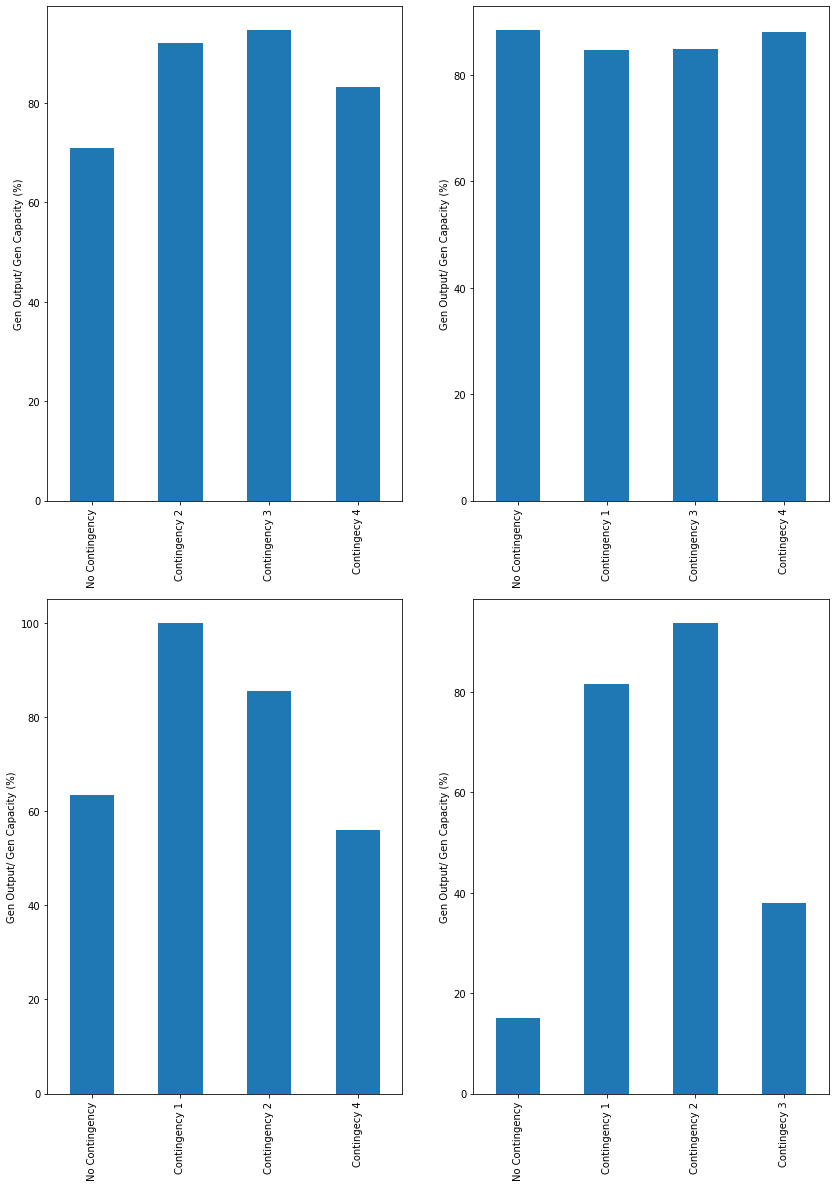

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
gen_data1 = [gen_noc[0],gen_data[4],gen_data[8],gen_data[12]]
gen_data2 = [gen_noc[1],gen_data[1],gen_data[9],gen_data[13]]
gen_data3 = [gen_noc[2],gen_data[2],gen_data[6],gen_data[14]]
gen_data4 = [gen_noc[3],gen_data[3],gen_data[7],gen_data[11]]
gen1_index = ['No Contingency','Contingency 2', 'Contingency 3', 'Contingecy 4']
gen2_index = ['No Contingency','Contingency 1', 'Contingency 3', 'Contingecy 4']
gen3_index = ['No Contingency','Contingency 1', 'Contingency 2', 'Contingecy 4']
gen4_index = ['No Contingency','Contingency 1', 'Contingency 2', 'Contingecy 3']
gen1_pl = pd.DataFrame(gen_data1, gen1_index)
gen2_pl = pd.DataFrame(gen_data2, gen2_index)
gen3_pl = pd.DataFrame(gen_data3, gen3_index)
gen4_pl = pd.DataFrame(gen_data4, gen4_index)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (14,20))
gen1_pl.plot.bar(ax=axes[0,0],legend = None,ylabel = 'Gen Output/ Gen Capacity (%)')
gen2_pl.plot.bar(ax=axes[0,1],legend = None,ylabel = 'Gen Output/ Gen Capacity (%)')
gen3_pl.plot.bar(ax=axes[1,0],legend = None,ylabel = 'Gen Output/ Gen Capacity (%)')
gen4_pl.plot.bar(ax=axes[1,1],legend = None,ylabel = 'Gen Output/ Gen Capacity (%)')

#### Conclusion of the observation
Gen 4 needs to ramp up too much in contingency. Later, we will impose ramping constraint to Gen 4 in time series.

### Economic Dispatch
We can just remove the line loading constraint from the system which will cover in the next part. In ED, the constraint will be to fulfill demand with all the generating units, and flexibility available in the network.